In [83]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive/efficientnet-v2'
import os
os.chdir(drive_path)

Mounted at /content/drive


In [84]:
# !pip install tensorflow= 2.5.0
# !pip install tensorflow_hub= 0.12.0

In [85]:
import json
import shutil
from skimage.io import imread, imsave
from glob import glob
import cv2
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')

In [87]:
model_dir = os.path.join(drive_path, 'models')
model_base = '20210720_hirox_2class' # @param {type:"string"}
assert os.path.exists(os.path.join(model_dir, model_base))

best_epoch_path = os.path.join(model_dir, model_base, 'best_epoch.txt')
if os.path.exists(best_epoch_path):
    with open(best_epoch_path, 'r') as f:
        best_epoch = int(f.read())
    print('best epoch:', best_epoch)
else:
    print('no best-epoch file')

best epoch: 14


In [89]:
best_epoch =  14# @param {type:"integer"}
get_custom_objects().update({'swish_act': SwishActivation(swish_act), 
                             'KerasLayer': KerasLayer})
model_dir = os.path.join(drive_path, 'models')

# クラス名の読み込み
class_dict_path = os.path.join(model_dir, model_base, 'class_dict.json')
with open(class_dict_path) as f:
    class_dict = json.load(f)
print(class_dict)
class_names = list(class_dict.keys())

{'noise': 0, 'tooth': 1}


In [90]:
Site_ID = 'Site_1179' # @param{type:"string"}
Sample_ID = '1179C_24_05_75'# @param{type:"string"}
excel_path = f'/content/drive/My Drive/ai_ichthyolith/data/annotations/{Sample_ID}/{Sample_ID}_detections.xlsx'
hirox_image_dir = f'/content/drive/MyDrive/ai_ichthyolith/data/images/hirox/{Site_ID}/{Sample_ID}'
draw_img_dir = os.path.join(drive_path, 'results', model_base, Sample_ID)

for path in [excel_path, hirox_image_dir]:
    assert os.path.exists(path), f"path not exists: {path}"

In [91]:
# Mask R-CNN の検出結果の excel を利用する場合
save_excel_name = 'mask_enet_results.xlsx' #@param {type:"string"}
save_excel_path = os.path.join(draw_img_dir, save_excel_name)
df = pd.read_excel(save_excel_path, index_col=0)
df = df.rename(columns={'cropped_name': 'cropped_imgName'})
df = df.sort_values('cropped_imgName')
df = df.reset_index(drop=True)
df

,id,original_slide_name,x_min,y_min,x_max,y_max,all_points_x,all_points_y,size,length,cropped_imgName,mode,class,detected_class,score,judge,enet_class,enet_score,trimmed_ImgName,length_note
0,691,1179C_24_05_75_001.jpg,136,164,1093,450,"753, 752, 740, 739, 724, 723, 692, 691, 682, 6...","189, 190, 190, 191, 191, 190, 190, 191, 191, 1...",130026.393978,920.0,1179C_24_05_75_001_0_0.jpg,detection_results,NaN,tooth,0.641602,fp,noise,0.031353,1179C_24_05_75_001_134_106.jpg,NaN
1,765,1179C_24_05_75_001.jpg,19,363,284,1200,"175, 174, 174, 173, 173, 172, 172, 171, 171, 1...","1142, 1143, 1145, 1146, 1148, 1149, 1150, 1151...",147.814101,14.0,1179C_24_05_75_001_0_0.jpg,detection_results,NaN,tooth,0.508301,fp,noise,0.156170,1179C_24_05_75_001_333_0.jpg,NaN
2,461,1179C_24_05_75_001.jpg,10138,7,11267,286,"10695, 10694, 10678, 10677, 10669, 10668, 1065...","12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18...",226496.317892,1088.0,1179C_24_05_75_001_0_10080.jpg,detection_results,NaN,tooth,0.954590,fp,noise,0.046477,1179C_24_05_75_001_0_10108.jpg,NaN
3,623,1179C_24_05_75_001.jpg,10976,31,11119,102,"11052, 11051, 11049, 11048, 11047, 11044, 1104...","32, 33, 33, 34, 34, 37, 37, 40, 40, 41, 41, 42...",5145.847636,114.0,1179C_24_05_75_001_0_10920.jpg,detection_results,NaN,tooth,0.763184,fp,noise,0.067140,1179C_24_05_75_001_1_10946.jpg,NaN
4,367,1179C_24_05_75_001.jpg,10984,24,12112,481,"11228, 11227, 11176, 11175, 11156, 11155, 1114...","29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35...",377858.376094,1069.0,1179C_24_05_75_001_0_10920.jpg,detection_results,NaN,tooth,0.987305,fp,noise,0.026983,1179C_24_05_75_001_0_10954.jpg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4413,4110,1179C_24_05_75_006.jpg,32790,9449,33101,10076,"32988, 32987, 32981, 32980, 32978, 32977, 3297...","9450, 9451, 9451, 9452, 9452, 9453, 9453, 9454...",160643.174400,575.0,1179C_24_05_75_006_9240_31920.jpg,detection_results,NaN,tooth,0.905762,fp,noise,0.052433,1179C_24_05_75_006_9419_32760.jpg,NaN
4414,4067,1179C_24_05_75_006.jpg,7275,10094,7629,10306,"7317, 7316, 7306, 7305, 7303, 7302, 7301, 7297...","10094, 10095, 10095, 10096, 10096, 10097, 1009...",49105.779689,332.0,1179C_24_05_75_006_9240_6720.jpg,detection_results,NaN,tooth,0.937012,fp,noise,0.048251,1179C_24_05_75_006_10064_7245.jpg,NaN
4415,4159,1179C_24_05_75_006.jpg,7560,10176,7627,10267,"7561, 7561, 7560, 7560, 7561, 7561, 7563, 7565...","10179, 10182, 10183, 10261, 10262, 10264, 1026...",5091.840000,82.0,1179C_24_05_75_006_9240_7560.jpg,detection_results,NaN,tooth,0.848145,fp,noise,0.042383,1179C_24_05_75_006_10146_7560.jpg,NaN
4416,4118,1179C_24_05_75_006.jpg,7867,9988,7942,10147,"7895, 7894, 7893, 7891, 7891, 7890, 7890, 7889...","10005, 10006, 10006, 10008, 10009, 10010, 1001...",6556.636126,133.0,1179C_24_05_75_006_9240_7560.jpg,detection_results,NaN,tooth,0.899414,fp,noise,0.052914,1179C_24_05_75_006_9958_7837.jpg,NaN


In [92]:
def generateImg_from_crop(crop_img, box, filename, margin = 30, all_points_x = None, all_points_y = None):
    """
    box : y_min, x_min, y_max, x_max
    """
    y0, x0 = map(int, filename[:-4].split('_')[-2:])
    y_start = max(box[0] - y0 - margin, 0)
    y_end = min(box[2] - y0 + margin, crop_img.shape[0])
    x_start = max(box[1] - x0 - margin, 0)
    x_end = min(box[3] - x0 + margin, crop_img.shape[1])
    trimmed_img = crop_img[y_start:y_end, x_start:x_end]
    savename = f"{'_'.join(filename[:-4].split('_')[:-2])}_{y0 + y_start}_{x0 + x_start}.jpg"
    if any([all_points_x is None, all_points_y is None]):
        return(trimmed_img, savename)
    else:
        all_points_x -= (x0 + x_start)
        all_points_y -= (y0 + y_start)
        return(trimmed_img, savename, all_points_x, all_points_y) 

In [93]:
def str2array(string):
    arr = np.array(list(map(int, string.split(', '))))
    return(arr)

In [94]:
save_dir = os.path.join(draw_img_dir, '20211121_for_paper')
os.makedirs(save_dir, exist_ok=True)

1179C_24_05_75_003_12600_15960.jpg


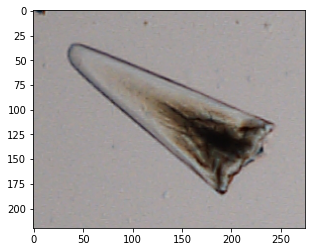

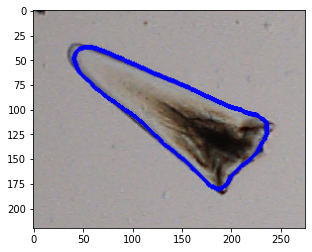

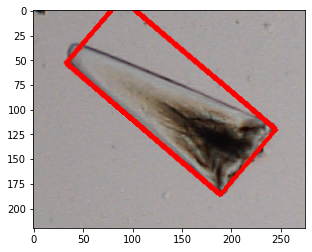

In [99]:
df_tp = df[df['judge'] == 'tp']
for index, item in df_tp.iloc[46:47, :].iterrows():
    filename = item['cropped_imgName']
    print(filename)
    slide_No = filename.split('_')[Sample_ID.count('_') + 1]
    img_path = f"{hirox_image_dir}/{Sample_ID}_{slide_No}/{filename}"
    crop_img = imread(img_path)
    box = list(item[['y_min', 'x_min', 'y_max', 'x_max']])
    all_points_x = str2array(item['all_points_x'])
    all_points_y = str2array(item['all_points_y'])
    img, img_name, all_points_x, all_points_y = generateImg_from_crop(crop_img, box, filename, margin = 30, all_points_x=all_points_x, all_points_y=all_points_y)
    plt.imshow(img)
    plt.show()

    ctr = np.array([all_points_x, all_points_y]).T
    img_ctr = img.copy()
    img_ctr = cv2.drawContours(img_ctr, [ctr], 0, (0, 0, 255), 3)
    plt.imshow(img_ctr)
    plt.show()
    rect = cv2.minAreaRect(ctr)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    img_box = img.copy()
    img_box = cv2.drawContours(img_box,[box],0,(255,0,0),3)
    plt.imshow(img_box)
    plt.show()

    save_path_1 = os.path.join(save_dir, f"01_{filename}")
    imsave(save_path_1, img)
    save_path_2 = os.path.join(save_dir, f"02_{filename[:-4]}_contour.jpg")
    imsave(save_path_2, img_ctr)
    save_path_3 = os.path.join(save_dir, f"03_{filename[:-4]}_box.jpg")
    imsave(save_path_3, img_box)
    
    